In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd drive
# %cd 'My Drive'
# %cd 'IS projects'
# %cd CL
# %cd DataSets

/content/drive
/content/drive/My Drive
/content/drive/My Drive/IS projects
/content/drive/My Drive/IS projects/CL
/content/drive/My Drive/IS projects/CL/DataSets


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.sparse import csgraph
from copy import deepcopy
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.cm as cm
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

THRESHOLD = .4
X = 0
Y = 1
K = 5
newcmp = ListedColormap(['#B79FE7', '#cebeef','#3D1E5B', '#C1ADD6',  '#A384C1', '#845BAD', '#3D1E5B', '#e6def7', '#4d279b'])

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import scipy

In [3]:
def seperation_index(data, cluster_indices, p = 2):

    def intra_distance(cluster, p = 2): #Calculates maximum intra-cluster distance

        if(p ==2):
            return np.amax(pairwise_distances(cluster, metric = "euclidean"))

        else:
            pairwise = np.zeros((len(cluster), len(cluster)))
            for i in range(len(cluster)):
                for j in range(len(cluster)):
                    pairwise[i][j] = np.linalg.norm(cluster[i] - cluster[j], p)
            print(pairwise)
        return np.amax(pairwise)

    def inter_distance(cluster1, cluster2, p = 2):  #Calculates minimum inter-cluster distance (single-link)
        x = np.zeros((len(cluster1), len(cluster2)))
        x = [[np.linalg.norm(cluster1[i]-cluster2[j], p) for i in range(len(cluster1)) ] for j in range(len(cluster2))]
        return np.amin(x)
    
        
    num_clusters = len(np.unique(cluster_indices))
    cluster_mapping = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        cluster_mapping[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]


    temp = []
    if(num_clusters == 1):
        return 0
    
    for j in range(num_clusters):
        
        inner_temp = []
        for i in range(num_clusters):
            if(i!=j):# Iterating over other clusters after fixing one cluster
                
                # Higher Seperation for Algorithm with further clusters:
                num = inter_distance(data[np.where(cluster_indices ==i)], data[np.where(cluster_indices ==j)], p) 
               
                # Higher Seperation for Algorithm with denser clusters 
                den = np.amax([intra_distance(data[np.where(cluster_indices ==l)], p)  for l in range(num_clusters)]) #
                
                # Normalizing numerators across the whole cluster pairs with the denumerator 
                inner_temp.append(num/den) 
                
    temp.append(min(inner_temp)) 

    seperation_index = min(temp) # Assuming a pessimistic lowerbound along the seperation metric for all pairs

    return seperation_index
        

In [4]:
def fisher_index(data, cluster_indices):
    num_clusters = len(np.unique(cluster_indices))
    data_dimension = len(data[0])
    
    epsilon = (np.amax(data)-np.amin(data))/(10**5) # Preventing Singularity of Sw
    clusters = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        clusters[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]

    if(num_clusters==1):
        return 0
    
    centroids = []
    
    Sw = np.zeros((data_dimension, data_dimension))
    for i in range(len(clusters)):
        Si = np.zeros((data_dimension, data_dimension))
        for q in range(len(clusters[i])):
            
            # Calculating Variance Matrix to obtain Si & Sw
            mul = np.matmul(np.transpose(np.array([clusters[i][q] - np.mean(clusters[i][q])])), np.array([clusters[i][q] - np.mean(clusters[i][q])]))
            Si = np.add(Si, mul)
            
        centroids.append(np.mean(clusters[i], axis = 0)) # Calculating Clusters Centroids
    Sw = np.add(Sw, Si)
    
    
    total_centroid  = np.mean(centroids, axis = 0) # Calculating Between Cluster Covariability using Centroids Covariance Matrix
    Sb = np.zeros((data_dimension, data_dimension))
    
    for i in range(num_clusters):
        Sb = np.add(Sb, np.matmul(np.transpose(np.array([(centroids[i] - (total_centroid))])), np.array([(centroids[i] - (total_centroid))])))
    
    Sw = np.add(Sw, epsilon*np.eye(data_dimension))
    FDI = np.trace(np.matmul(np.linalg.inv(Sw), Sb)) 
    return FDI


In [5]:
def barchart_comparison(algorithms, seperations, fdis, clr = '#7756a7', title = None): #Gets list of Algorithm Names and Corresponding Seo, Fisher Metrics

    fig, ax = plt.subplots(1, 2, figsize = (20, 7))
    fig.tight_layout(pad = 10.0)

    y_pos = np.arange(len(algorithms))
    ax[0].barh(algorithms, seperations, color = clr)
    ax[0].set_xlabel('Seperation Indices')

    ax[1].barh(algorithms, fdis, color = clr)
    ax[1].set_xlabel('FDI')

    plt.show()

### Reading the data

In [6]:
read_data =  lambda filename :  pd.read_csv(filename).to_numpy()

In [7]:
vectorizer = lambda x: 1 if x < THRESHOLD else 0

### Visualizing graphs

In [8]:
toy_data_set = read_data('ToyDataSet.csv')

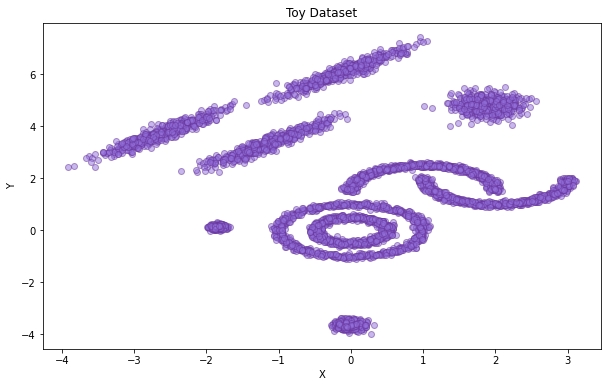

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(toy_data_set[:,0], toy_data_set[:,1], color = 'mediumpurple' , alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset')
plt.show()

In [10]:
class SpectralClustering:
  def __init__(self, data, method):
    self.data = data
    self.method = method
    self.similarity_matrix = pairwise_distances(data, metric = "euclidean")

  def compute_affinity_matrix(self, local_scale):
    self.affinity_matrix = -self.similarity_matrix**2 / local_scale
    self.affinity_matrix[np.where(np.isnan(self.affinity_matrix))] = 0.0
    self.affinity_matrix = np.exp(self.affinity_matrix)
    np.fill_diagonal(self.affinity_matrix, 0)

  def compute_scale(self, k):
    knn_distances = (np.sort(self.similarity_matrix, axis = 0)[k])[np.newaxis].T
    return knn_distances.dot(knn_distances.T)

  def compute_laplacian_matrix(self, *argv):
    if self.method == "epsilon neighborhood" :
        adjacency_matrix =  np.vectorize(np.vectorize(vectorizer))(self.similarity_matrix)
        degree_matrix = np.diag(np.sum(adjacency_matrix , axis=1))
        self.laplacian_matrix = degree_matrix - adjacency_matrix

    if self.method == "k nearest neighborhood" :
      local_scale = self.compute_scale(argv[0])
      self.compute_affinity_matrix(local_scale)
      self.laplacian_matrix = csgraph.laplacian(self.affinity_matrix, normed = True)

  def eigen_decomposition(self): self.eigenvalues, self.eigenvectors = np.linalg.eig(self.laplacian_matrix)

  def compute_eigenvals(self):
    self.compute_laplacian_matrix(K)
    self.eigen_decomposition()

  def tune_spectral_clustering(self):
    self.compute_eigenvals()
    self.eigenvals_sorted_indices = np.argsort(self.eigenvalues)
    self.eigenvals_sorted = self.eigenvalues[self.eigenvals_sorted_indices]
    self.n_componets = self.eigenvalues[np.argwhere(abs(self.eigenvalues) < 1e-7)].shape[0]

  def set_n_componets(self, hand_picked_n) : self.n_componets = hand_picked_n

  def fit(self):
    k_means = KMeans(self.n_componets)
    k_means.fit(self.data)
    self.clusters = k_means.predict(self.data)


In [11]:
def plotting(title, label, data, scatter = True):
  plt.figure(figsize=(10, 6))
  plt.title(title)
  if scatter : plt.scatter(data[X], data[Y], color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
  else : plt.plot(data[X], data[Y], color = 'mediumpurple')
  plt.xlabel(label[X])
  plt.ylabel(label[Y])

In [12]:
def eigengap_heuristic(topK, eigenvalues):
  index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
  n_componets = index_largest_gap + 1
  return n_componets

In [13]:
SC_model = SpectralClustering(data = toy_data_set, method = "k nearest neighborhood")
SC_model.tune_spectral_clustering()
SC_model.fit()

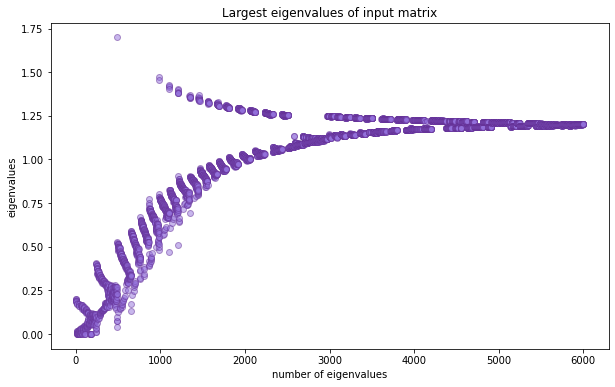

In [14]:
plotting('Largest eigenvalues of input matrix', ['number of eigenvalues' ,'eigenvalues'],[np.arange(len(SC_model.eigenvalues)), SC_model.eigenvalues] )

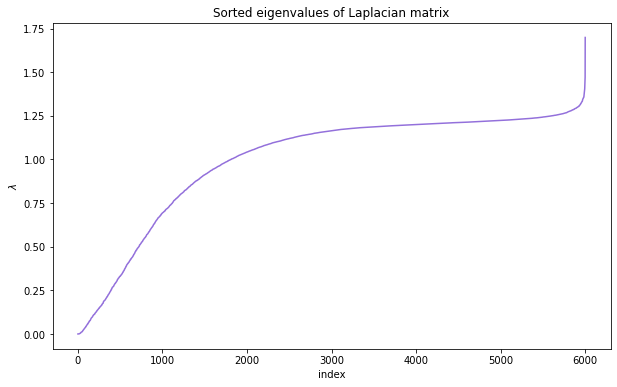

In [15]:
plotting('Sorted eigenvalues of Laplacian matrix', ['index' ,r'$\lambda$'], [range(1, SC_model.eigenvals_sorted_indices.size + 1), SC_model.eigenvals_sorted], False)

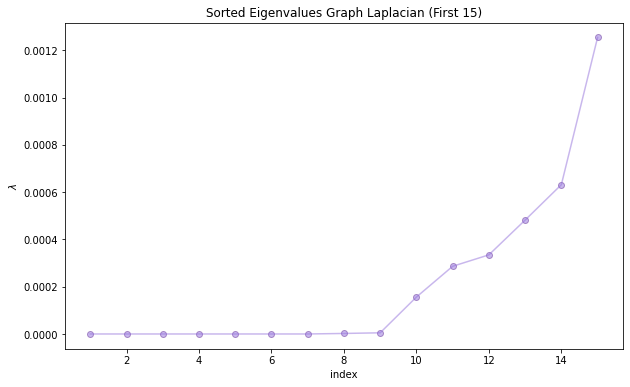

In [16]:
index_lim = 15
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim] , color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
plt.plot(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim], alpha = 0.5, color = 'mediumpurple')
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel = 'index', ylabel = r'$\lambda$');

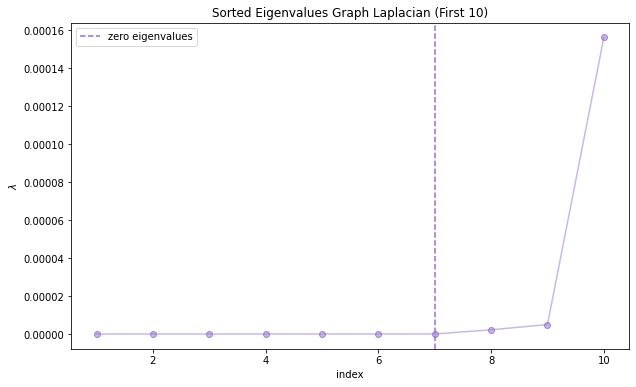

In [17]:
index_lim = 10
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim] , color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
plt.plot(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim], alpha = 0.5, color = 'mediumpurple')
ax.axvline(x = 7, color = 'mediumpurple', label = 'zero eigenvalues', linestyle  ='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel = 'index', ylabel = r'$\lambda$');

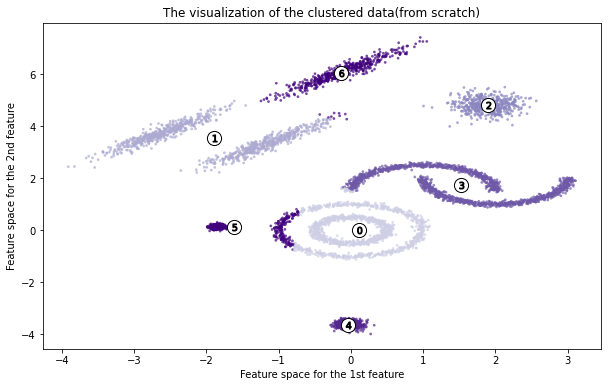

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(SC_model.clusters.astype(float) / np.unique(SC_model.clusters).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data_set[SC_model.clusters == i], axis = 0) for i in range(np.unique(SC_model.clusters).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(from scratch)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [21]:
print(np.unique(SC_model.clusters))

[0 1 2 3 4 5 6]


### Metric Evaluation

In [25]:
sep_ind = []
fda_ind = []

sep_ind.append(seperation_index(toy_data_set, SC_model.clusters))

fda_ind.append(fisher_index(toy_data_set, SC_model.clusters))

print(sep_ind)
print(fda_ind)

[0.01390545029135358]
[380224.1517279532]


In [26]:
n_componets = eigengap_heuristic(topK = 10 , eigenvalues = SC_model.eigenvalues)
n_componets

array([ 485,  981, 1101, 1205, 1342, 1448, 1557,  490,  652, 1667])

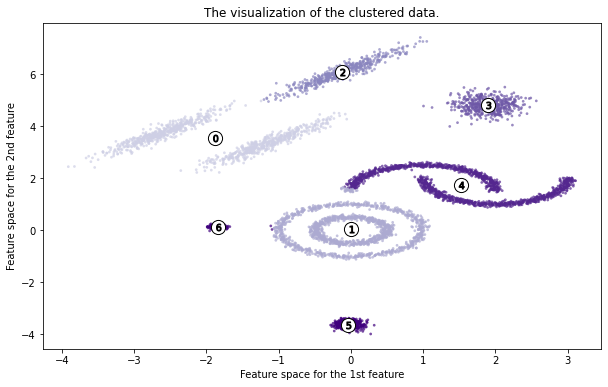

In [28]:
sc = sklearn.cluster.SpectralClustering(n_clusters = SC_model.n_componets)
sc_clustering = sc.fit(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(sc_clustering.labels_.astype(float) / np.unique( sc_clustering.labels_).shape[0] + 0.3 )

ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data_set[sc.labels_ == i], axis = 0) for i in range(np.unique(sc.labels_).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_title("The visualization of the clustered data.")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()



---

---

---







In [29]:
bboxes_data_set = read_data('bboxes.csv')

In [30]:
norm_bboxes = np.zeros((bboxes_data_set.shape[0], 2))
norm_bboxes[:, 0] = (bboxes_data_set[:, 4] - bboxes_data_set[:, 2]) / bboxes_data_set[:, 0]
norm_bboxes[:, 1] = (bboxes_data_set[:, 5] - bboxes_data_set[:, 3]) / bboxes_data_set[:, 1]

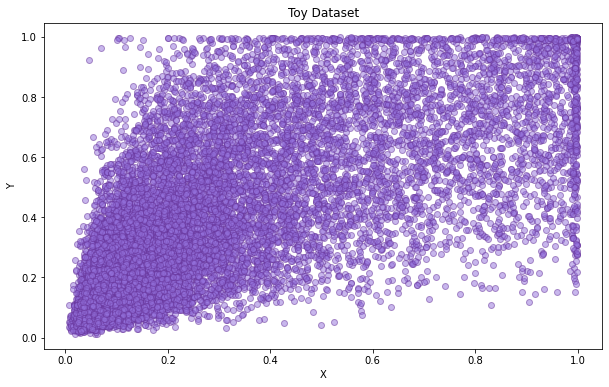

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(norm_bboxes[:,0], norm_bboxes[:,1], color = 'mediumpurple' , alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset')
plt.show()

due to time complexity, we cant do it  :)

In [47]:
np.random.shuffle(norm_bboxes)
sample_norm_bboxes = norm_bboxes[0:10000,:]

In [48]:
norm_bboxes.shape

(15662, 2)

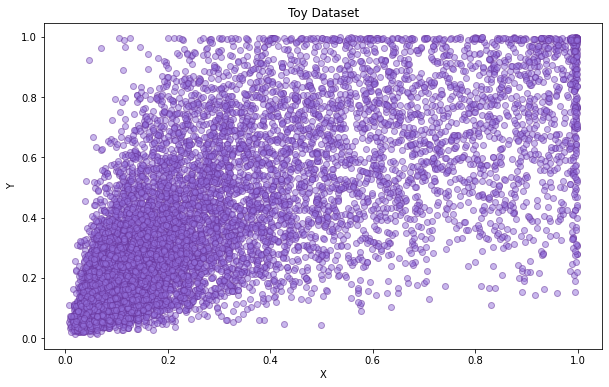

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(sample_norm_bboxes[:,0], sample_norm_bboxes[:,1], color = 'mediumpurple' , alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset')
plt.show()

In [50]:
K = 5
SC_model = SpectralClustering(data = sample_norm_bboxes, method = "k nearest neighborhood")
SC_model.tune_spectral_clustering()

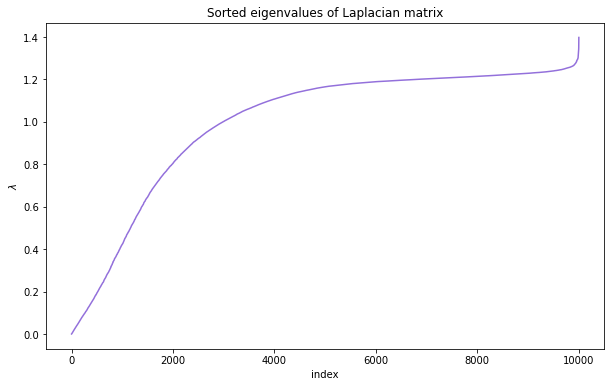

In [51]:
plotting('Sorted eigenvalues of Laplacian matrix', ['index' ,r'$\lambda$'], [range(1, SC_model.eigenvals_sorted_indices.size + 1), SC_model.eigenvals_sorted], False)

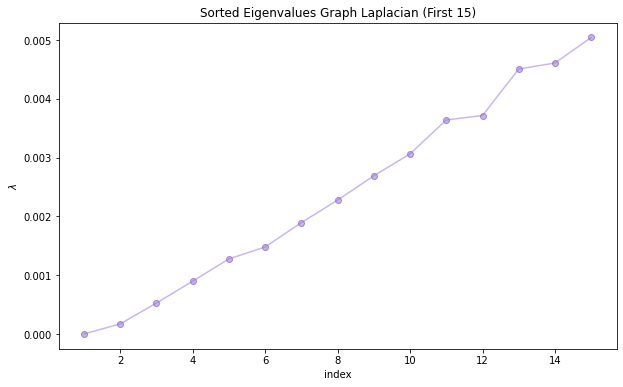

In [52]:
index_lim = 15
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim] , color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
plt.plot(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim], alpha = 0.5, color = 'mediumpurple')
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel = 'index', ylabel = r'$\lambda$');

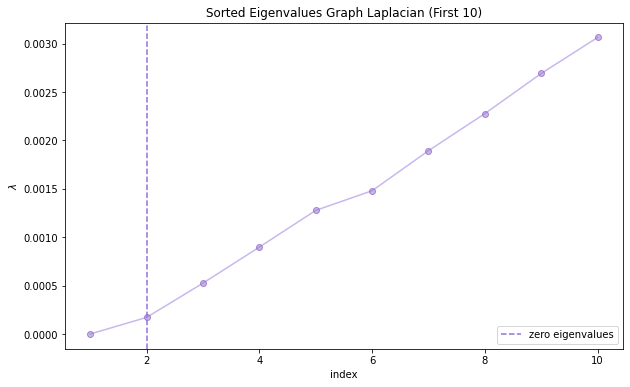

In [53]:
index_lim = 10
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim] , color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
plt.plot(range(1, SC_model.eigenvals_sorted_indices[: index_lim].size + 1), SC_model.eigenvals_sorted[: index_lim], alpha = 0.5, color = 'mediumpurple')
ax.axvline(x = 2, color = 'mediumpurple', label = 'zero eigenvalues', linestyle  ='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel = 'index', ylabel = r'$\lambda$');

In [54]:
n_componets = eigengap_heuristic(topK = 10 , eigenvalues = SC_model.eigenvalues)
n_componets

array([2002, 2061, 2310, 2387, 2467, 2551, 2637, 2739, 2852, 2982])

In [55]:
SC_model.fit()

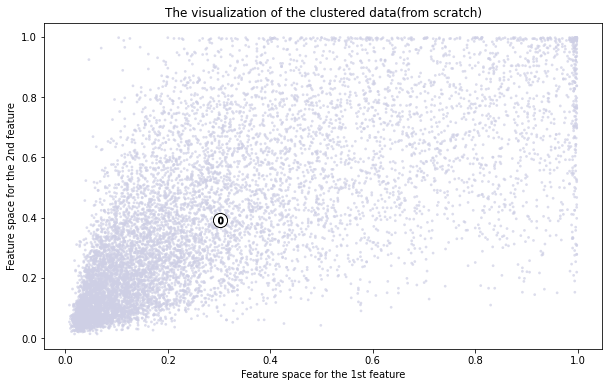

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(SC_model.clusters.astype(float) / np.unique(SC_model.clusters).shape[0] + 0.3 )
ax.scatter(sample_norm_bboxes[:, 0], sample_norm_bboxes[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(sample_norm_bboxes[SC_model.clusters == i], axis = 0) for i in range(np.unique(SC_model.clusters).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(from scratch)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

### Metric Evaluation

In [44]:
#sep_ind.append(seperation_index(sample_norm_bboxes, SC_model.clusters))
#fda_ind.append(fisher_index(sample_norm_bboxes, SC_model.clusters))

print(sep_ind)
print(fda_ind)


[0.01390545029135358, 0]
[380224.1517279532, 0]


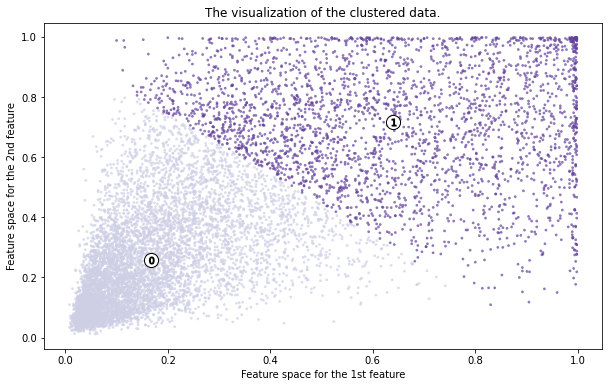

In [53]:
sc = sklearn.cluster.SpectralClustering(n_clusters = SC_model.n_componets)
sc_clustering = sc.fit(sample_norm_bboxes)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(sc_clustering.labels_.astype(float) / np.unique( sc_clustering.labels_).shape[0] + 0.3 )

ax.scatter(sample_norm_bboxes[:, 0], sample_norm_bboxes[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(sample_norm_bboxes[sc.labels_ == i], axis = 0) for i in range(np.unique(sc.labels_).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_title("The visualization of the clustered data.")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

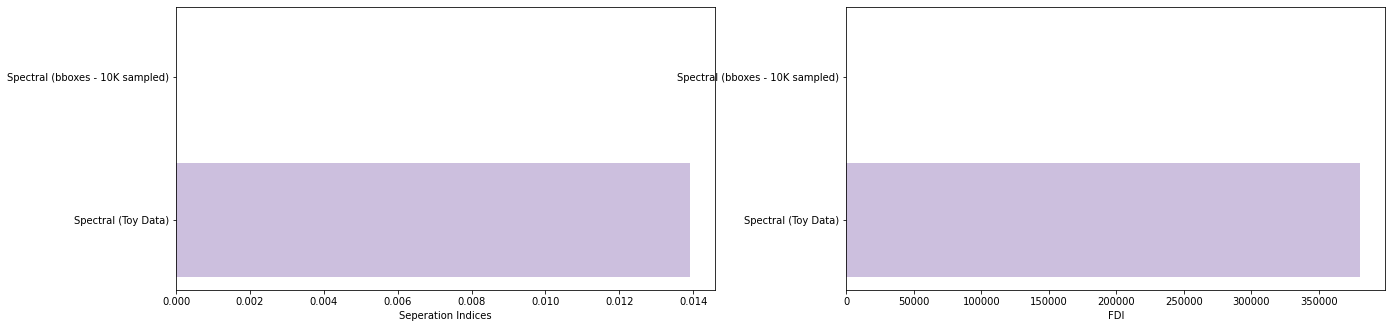

In [46]:
algorithms = ['Spectral (Toy Data)', 'Spectral (bboxes - 10K sampled)']

barchart_comparison(algorithms, sep_ind, fda_ind, clr = '#ccbfde')